In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# read in the data with headers
diamonds = pd.read_csv("diamonds.csv", index_col=0)

# check the data
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


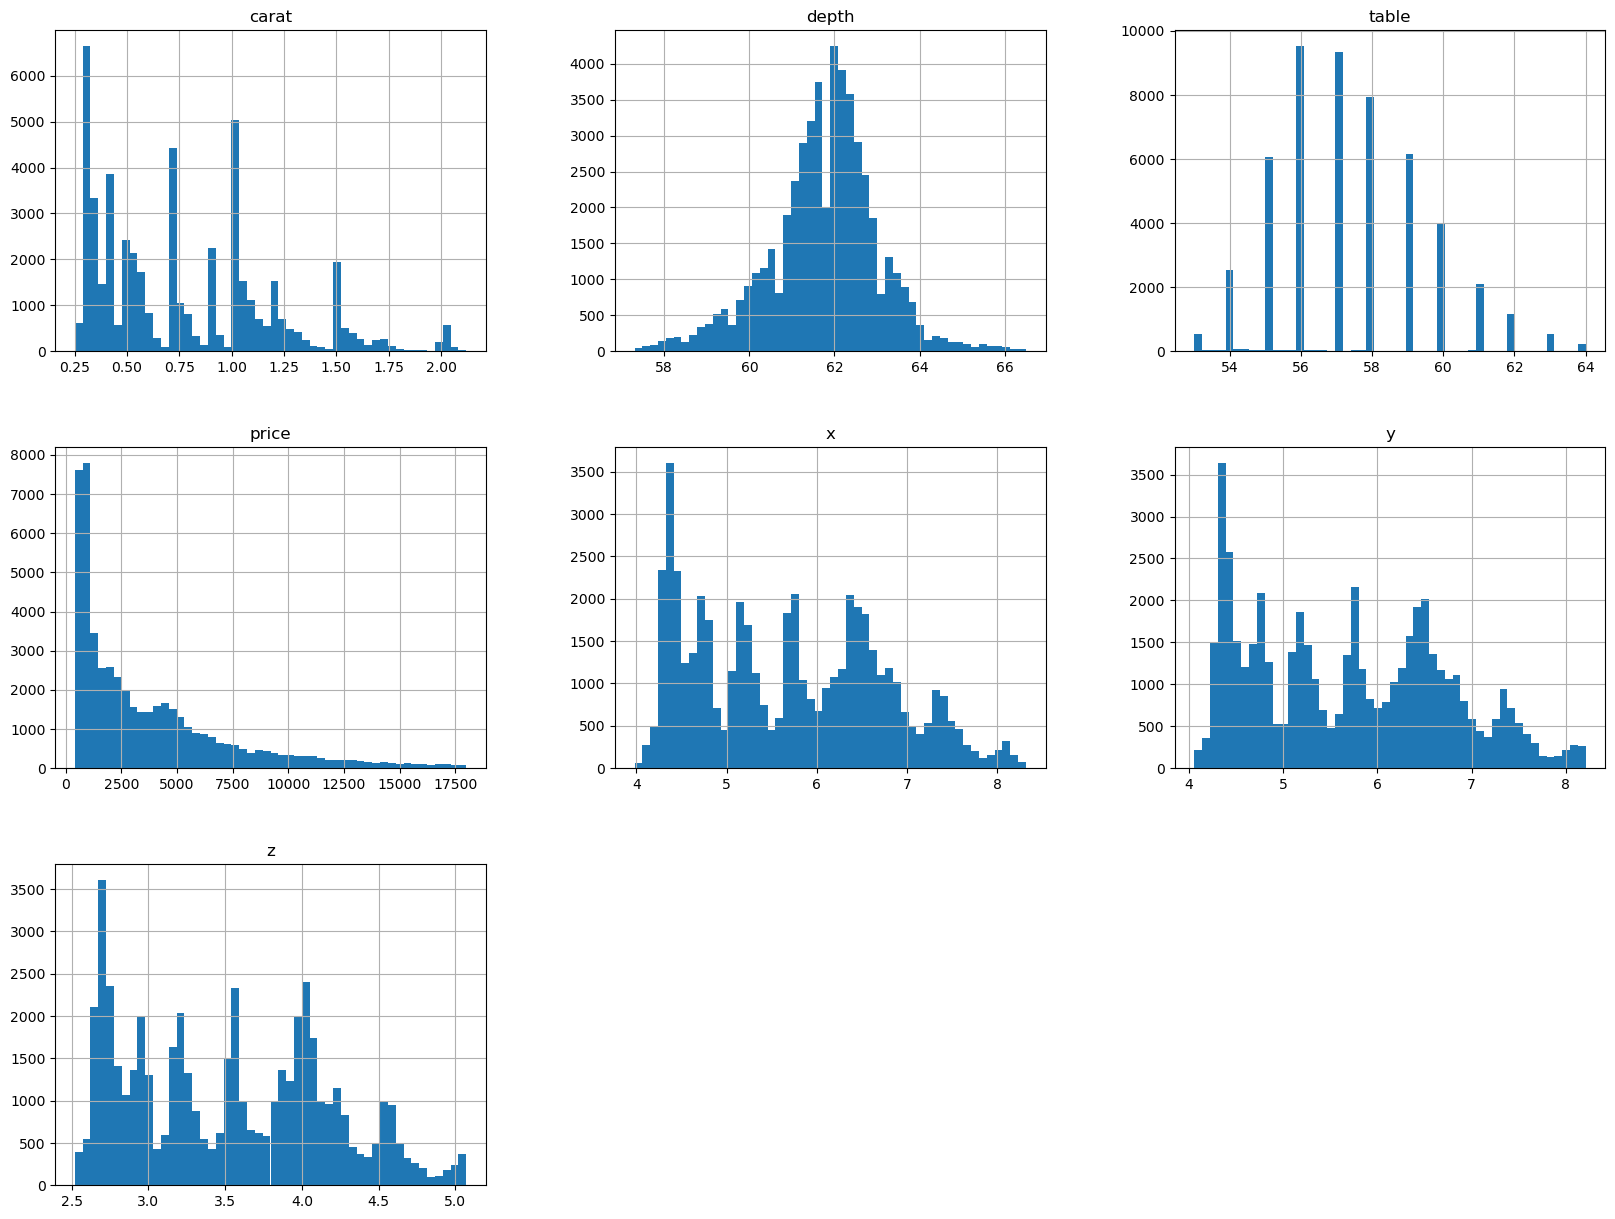

In [2]:
diamonds2 = diamonds.copy()

for col in diamonds2.columns:
    if diamonds2[col].dtype != "object":
        diamonds2 = diamonds2[
            (diamonds2[col] >= np.percentile(diamonds2[col], 0.5))
            & (diamonds2[col] <= np.percentile(diamonds2[col], 99.5))
        ]
        diamonds2.reset_index(drop=True, inplace=True)

diamonds2.shape

diamonds2.hist(bins=50, figsize=(20, 15))
plt.show()

In [3]:
from sklearn.model_selection import train_test_split

# split data into training, validation, and test sets
train, test = train_test_split(diamonds2, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.25, random_state=42)

In [4]:
# create a list of features
features = ["carat", "cut", "color", "clarity", "x", "y", "z", "table", "depth"]
# create X matrix and y vector
X_train = train[features]
y_train = train["price"]
X_val = val[features]
y_val = val["price"]
X_test = test[features]
y_test = test["price"]

In [5]:
# preprocess the categorical features (one-hot encode)
X_train = pd.get_dummies(X_train, columns=["cut", "color", "clarity"])
X_val = pd.get_dummies(X_val, columns=["cut", "color", "clarity"])
X_test = pd.get_dummies(X_test, columns=["cut", "color", "clarity"])

# check the shape of the data

In [6]:
# check first five rows of training data

X_train.head()

,carat,x,y,z,table,depth,cut_Fair,cut_Good,cut_Ideal,cut_Premium,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
5385,0.90,6.10,6.14,3.77,63.0,61.6,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7754,1.15,6.73,6.67,4.14,57.0,61.8,0,0,1,0,...,0,1,0,0,1,0,0,0,0,0
40311,0.53,5.21,5.16,3.18,58.0,61.3,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
32113,0.41,4.73,4.76,2.98,57.0,62.8,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
40386,0.50,5.15,5.12,3.12,57.0,60.9,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [7]:
numeric_features = ["carat", "x", "y", "z", "table", "depth"]

# save mean and standard deviation of training data
means = X_train[numeric_features].mean()
stds = X_train[numeric_features].std()

# normalize the numeric features (subtract mean and divide by standard deviation)
X_train[numeric_features] = (X_train[numeric_features] - means) / stds
X_val[numeric_features] = (X_val[numeric_features] - means) / stds
X_test[numeric_features] = (X_test[numeric_features] - means) / stds

In [8]:
from sklearn.metrics import (
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
    mean_absolute_error,
)


def metrics(y_val, y_pred):
    mae = mean_absolute_error(y_val, y_pred)
    mape = mean_absolute_percentage_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)
    return mae, mape, mse, rmse, r2

# OLS

In [9]:
# write a Linear model to predict price from the features
from sklearn.linear_model import LinearRegression

# create a Linear Regression model
model = LinearRegression()

# fit the model on the training data (also called training the model)
model.fit(X_train, y_train)

# make predictions on the validation data
y_pred = model.predict(X_val)

# calculate the mean squared error of the predictions
mae, mape, mse, rmse, r2 = metrics(y_val, y_pred)

# print all metrics

In [10]:
print("MAE: %.3f" % mae)
print("MAPE: %.3f" % mape)
print("MSE: %.3f" % mse)
print("RMSE: %.3f" % rmse)
print("R2: %.3f" % r2)

MAE: 669.807
MAPE: 0.359
MSE: 1005091.211
RMSE: 1002.542
R2: 0.920


# Lasso 

In [11]:
# linear model with regularization (Lasso)
from sklearn.linear_model import Lasso

lasso_model = Lasso(alpha=0.5, random_state=42)
lasso_model.fit(X_train, y_train)
y_pred = lasso_model.predict(X_val)
mae, mape, mse, rmse, r2 = metrics(y_val, y_pred)

/mnt/disk1/mbbank/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.204e+09, tolerance: 3.970e+07
  model = cd_fast.enet_coordinate_descent(


In [12]:
print("MAE: %.3f" % mae)
print("MAPE: %.3f" % mape)
print("MSE: %.3f" % mse)
print("RMSE: %.3f" % rmse)
print("R2: %.3f" % r2)

MAE: 668.680
MAPE: 0.357
MSE: 1005199.011
RMSE: 1002.596
R2: 0.920


# Rigde reggression 

In [13]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=0.1, solver="cholesky")
ridge_reg.fit(X_train, y_train)
y_pred = ridge_reg.predict(X_val)
mae, mape, mse, rmse, r2 = metrics(y_val, y_pred)

print("MAE: %.3f" % mae)
print("MAPE: %.3f" % mape)
print("MSE: %.3f" % mse)
print("RMSE: %.3f" % rmse)
print("R2: %.3f" % r2)

MAE: 669.796
MAPE: 0.359
MSE: 1005025.953
RMSE: 1002.510
R2: 0.920


# MLP Regressor 

In [14]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(random_state=42)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_val) 

mae, mape, mse, rmse, r2 = metrics(y_val, y_pred)

print("MAE: %.3f" % mae)
print("MAPE: %.3f" % mape)
print("MSE: %.3f" % mse)
print("RMSE: %.3f" % rmse)
print("R2: %.3f" % r2)

MAE: 317.541
MAPE: 0.094
MSE: 325306.133
RMSE: 570.356
R2: 0.974


/mnt/disk1/mbbank/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [15]:
mlp.n_layers_ 

3